<a href="https://colab.research.google.com/github/salonishenoy/Intro_to_NN/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Derivitive of a function gives us
- how the function(equation) is affected when its inputs are slightly altered
- how sensitive the funciton is to changes in its inputs(slope)

In [49]:
class Value:  # to keep track of the scalar value
  def __init__(self, data):
    self.data = data

  def __repr__(self): # wrapper function to keep things neat
    return f"Value(data={self.data})"

In [50]:
a = Value(2.0)
b = Value(-3.0)

a, b

(Value(data=2.0), Value(data=-3.0))

In [51]:
a + b

TypeError: ignored

Python doesn't know how to add 'Value' objects hence the next function

In [52]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

In [53]:
a = Value(2.0)
b = Value(-3.0)

a + b

Value(data=-1.0)

In [54]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

In [55]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c

d

Value(data=4.0)

Now we introduce pointers in the functions to keep track of which values produce which other values

In [56]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0  # a gradient function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [57]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d *f ; L.label = 'L'

L

Value(data=-8.0)

In [58]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [59]:
d._op

'+'

In [60]:
# this is just for visualization

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

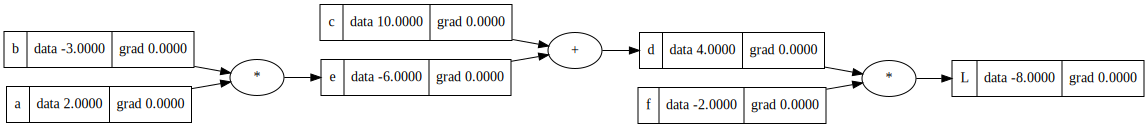

In [61]:
draw_dot(L)

The gradient function gives the derivative of L wrt to each input i.e how change in input affects the loss funtion(L)

In [62]:
def lol(): # to avoid polluting the global scope

  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d *f ; L.label = 'L'
  L1 = L.data   # L is a value node

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0 + h, label = 'f')
  L = d *f ; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

In [63]:
lol()

3.9999999999995595


lol() function example on top gave the derivative of 'f' wrt L = [dL/df]

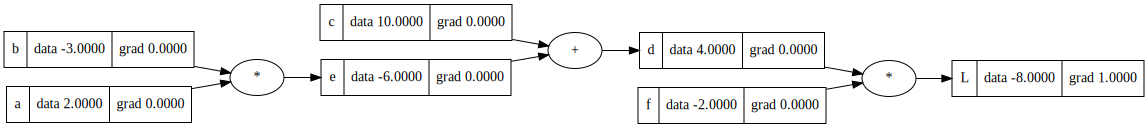

In [64]:
# Starting manual backpropagation

L.grad = 1
draw_dot(L)

Now,
dL/dd = d(d * f)/dd = f = -2

similarly:
dL\df = d = 4

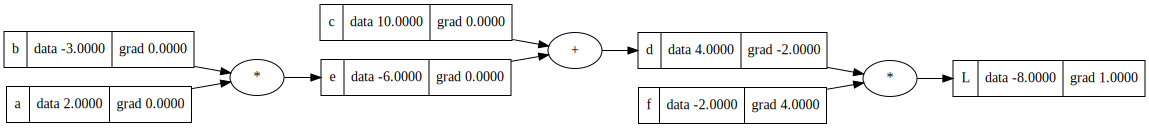

In [65]:
f.grad = 4.0
d.grad = -2.0

draw_dot(L)

By chain rule dL/dc = (dL/dd) * (dd/dc)  = -2.0 * 1 = -2.0

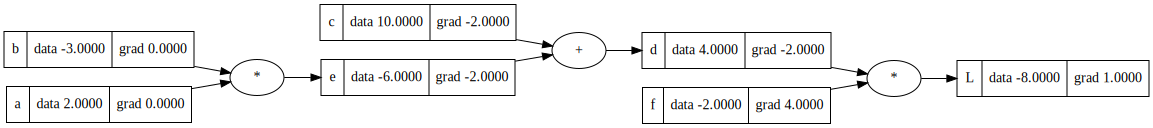

In [66]:
c.grad = -2.0
e.grad = -2.0

draw_dot(L)

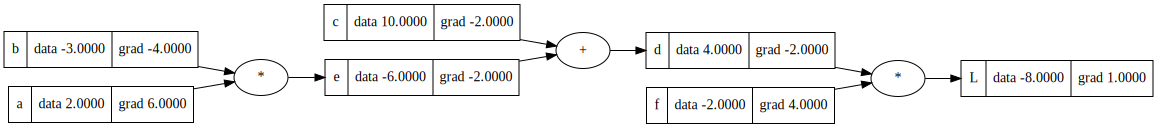

In [67]:
#similarly:

a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

draw_dot(L)

In [68]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#leaf nodes only since only they technically affect L

In [76]:
e = a * b
d = e + c
L = d * f
print(L.data)


-7.286496
